# COVID-19 time-series analysis

Jonathan Stickel, 2020

This purpose of this notebook (and repository) is to make available a set of time-series
analyses of COVID-19 data. Data sources are:

- https://github.com/CSSEGISandData/COVID-19 (Johns Hopkins CSSE COVID-19 data)
- https://data.worldbank.org/indicator/sp.pop.totl (population data)

By default, the COVID-19 data is grabbed from the Johns Hopkins CSSE github.com repository. When using this notebook on a local machine, you may instead clone the repo to an adjent folder and keep it up-to-date (see `websource` flag below).

Dependencies are:

- `numpy`
- `pandas`
- `scikit.datasmooth` (can be pip installed)

Also `findiffjs` is part of this repository.

binder URL for web-based "live" notebook: (??)

https://mybinder.org/v2/gh/jjstickel/covid-19_ts_analysis.git/master

TODO:
- **arrange related plots together**
- **Read data directly from URL**
- Process countries with multiple entries. Will need to make sure that the
  sum provides the correct result
- estimate current number sick (confirmed - deaths - recovered)
- add ability to read US data file (by state, city)
- (long term) switch from dict to class

In [30]:
# import modules
import numpy as np
import pandas as pd
from matplotlib.pyplot import *
import matplotlib.dates as mdates
from datetime import datetime
from decimal import Decimal
import scikits.datasmooth as ds # pip installed
from findiffjs import deriv1_fd

# User input

In [31]:
# Put up to 5 countries of interest in this list. Must be the
# same name used in the JH global files, and (at the moment), it must be a
# single entry in the file (e.g., China has multiple entries and will cause an
# Exception)
countries = ["US", "Italy", "Spain"]
# flag for using web or local address for the Johns Hopkins CSSE data
websource = True

In [32]:
# read in Johns Hopkins' data tables
if websource:
    pathname = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
else:
    pathname = "../JH_COVID-19/csse_covid_19_data/csse_covid_19_time_series/"
# read in global data
data_confirmed = pd.read_csv(pathname + "time_series_covid19_confirmed_global.csv")
data_deaths = pd.read_csv(pathname + "time_series_covid19_deaths_global.csv")
data_recovered = pd.read_csv(pathname + "time_series_covid19_recovered_global.csv")
# presume these files all have the same "fixed" structure -- could put in a
# check at some point
header = data_confirmed.columns.values
dates = pd.to_datetime(header[4:])
ndays = dates.size

In [33]:
# read in population data (source: https://data.worldbank.org/indicator/sp.pop.totl)
file_pop = "API_SP.POP.TOTL_DS2_en_csv_v2_887275/API_SP.POP.TOTL_DS2_en_csv_v2_887275_2018.csv"
data_pop = pd.read_csv(file_pop, header=4)

In [34]:
def read_cases(data, country):
    """
    Select country data values. The country data must be in a single row for the
    current implementation.
    """
    # get the row for the country
    c_bool = data["Country/Region"] == country
    c_data = data[c_bool]
    if c_data.shape[0] is 1:
        return np.squeeze(c_data.iloc[:,4:].values)
    else:
        raise Exception("Not implemented:  there is more than one row (or no rows) of %s data." % country)

def read_pop(data, country):
    """ Get the population for a country """
    # switch name of US country to match the entry in the population data file;
    # there may be more of these...
    if country is "US": country = "United States"
    row = data_pop[ data_pop["Country Name"]==country ]
    if row.size == 0:
        raise Exception("%s is not in the population data file" % country)
    return row.loc[:, "2018"].values[0]

In [35]:
# Create dictionary variable structure to hold each country's data and then read the data
nctry = len(countries)
corona = dict()
for country in countries:
    ctryd = dict()
    corona[country] = ctryd
    ctryd['name'] = country
    ctryd['population'] = read_pop(data_pop, country)
    ctryd['cnf'] = read_cases(data_confirmed, country)
    ctryd['dth'] = read_cases(data_deaths, country)
    ctryd['rec'] = read_cases(data_recovered, country)

The scaling factor for normalization and the criteria for determining zero-time are set here. I have tried a few values and have determined that these give consistently reasonable results.

In [36]:
##### scaling factor for cases, i.e., "deaths per mult" ######
mult=1e6
# low-value criterium to determine where to set zero time; using "confirmed" data for this
# because it seems less noisy than deaths
critlow = 10*1e-6 # for time zero, using confirmed

In [37]:
# normalization
def normalize_range(dates, ctryd, mult=mult, criteria=critlow):
    """
    calculate per capita cases (confirmed, deaths, and recovered) and scale
    elapsed time to a normalized point

    """
    pop = ctryd["population"]
    ctryd["cnf_pc"] = ctryd["cnf"]/pop*mult
    ctryd["dth_pc"] = ctryd["dth"]/pop*mult
    ctryd["rec_pc"] = ctryd["rec"]/pop*mult
    criteval = ctryd["cnf_pc"] > criteria*mult # use confirmed metric for time zero
    idx0 = np.nonzero(criteval)[0][0]
    ctryd["idx0"] = idx0
    ctryd["days"] = (dates - dates[idx0]).astype('timedelta64[D]').values
    return 

for country in countries:
    ctryd = corona[country]
    normalize_range(dates, ctryd)

Determine an exponential fit for the early part of the confirmed cases. As will be observed in the plots, it does not take very long before the growth of cases slows from exponential.

In [38]:
# compute exponential fit 
def expfit(t, y):
    """
    fit data to exponential function
    """
    k, lna = np.polyfit(t, np.log(y), 1)
    return np.exp(lna), k

crithigh = 200*1e-6 # upper bound for exponential fit, for fitting confirmed
for country in countries:
    ctryd = corona[country]
    criteval = ctryd['cnf_pc'] < crithigh*mult
    idx0 = ctryd['idx0']
    idx1 = np.nonzero(criteval)[0][-1]
    a, k = expfit(ctryd['days'][idx0:idx1], ctryd['cnf_pc'][idx0:idx1])
    dt2in = np.log(2)/k
    print("initial doubling time for %s was %g days" % (country, dt2in))
    ctryd['a'] = a
    ctryd['k'] = k
    ctryd['dt2in'] = dt2in
    ctryd['cnf_expfit'] = a*np.exp(k*ctryd['days'])

initial doubling time for US was 2.11097 days
initial doubling time for Italy was 2.96734 days
initial doubling time for Spain was 1.90011 days


In [39]:
# determine rates
lmbd=5e-5
for country in countries:
    ctryd = corona[country]
    if False:
        # smoothing, unconstrained
        ctryd['cnf_pc_h'] = ds.smooth_data(ctryd['days'], ctryd['cnf_pc'], d=2, lmbd=lmbd)
    else:
        # smoothing, with constraints
        # constrain cases to be non-negative
        Aones = -np.eye(ndays)
        bzero = np.zeros((ndays,1))
        # constrain cases to be always increasing
        D = -ds.derivative_matrix(ctryd['days'],1)
        bdzero = np.zeros((ndays-1,1))
        Aiq = np.vstack((Aones,D))
        biq = np.vstack((bzero, bdzero))
        ctryd['cnf_pc_h'] = ds.smooth_data_constr(ctryd['days'], ctryd['cnf_pc'], 2, lmbd,
                                                  (Aiq,biq))
        ctryd['dth_pc_h'] = ds.smooth_data_constr(ctryd['days'], ctryd['dth_pc'], 2, lmbd,
                                                  (Aiq,biq))
    # take the derivative
    ctryd['cnf_rate'] = deriv1_fd(ctryd['cnf_pc_h'], ctryd['days'], central=True)
    ctryd['dth_rate'] = deriv1_fd(ctryd['dth_pc_h'], ctryd['days'], central=True)

In [40]:
### plotting ###
rcParams.update({'font.size': 14})
figsize = (8,6)
clr = ['C%g' % i for i in range(10)]
sbl = ["o", "s", "v", "d", "h"]
savefigs = False

# get inverse human readable form for t=0 criterium
clinv_tup = Decimal("%.1g"%(1/critlow)).as_tuple()
clinv_dig = clinv_tup.digits[0]
clinv_exp = clinv_tup.exponent

N=0 # figure counter

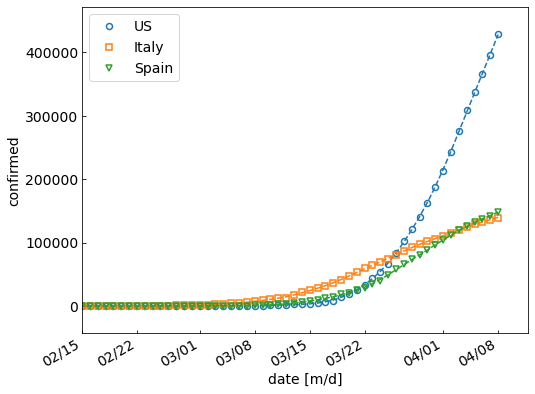

In [41]:
# total confirmed, not scaled
N+=1; figure(N, figsize=figsize)
clf()
for i in range(nctry):
    ctryd = corona[countries[i]]
    population = ctryd['population']
    plot(dates, ctryd['cnf'], sbl[i]+clr[i], mfc='none', mew=1.5, label=ctryd["name"])
    #plot(dates, ctryd['cnf_expfit']*population/mult, '-'+clr[i], lw=1.5)
    plot(dates, ctryd['cnf_pc_h']*population/mult, '--'+clr[i])
ax = gca()
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%m/%d"))
setp(ax.get_xticklabels(), rotation=30, ha="right")
cnf_max = max([corona[country]['cnf'].max() for country in countries])
axis(xmin = datetime(year=2020, month=2, day = 15), ymin=0-cnf_max*0.1, ymax = cnf_max*1.1)
xlabel("date [m/d]")
ylabel("confirmed")
legend(loc='best')
if savefigs:
    savefig("confirmed.pdf", bbox_inches="tight")
    savefig("confirmed.png", bbox_inches="tight")

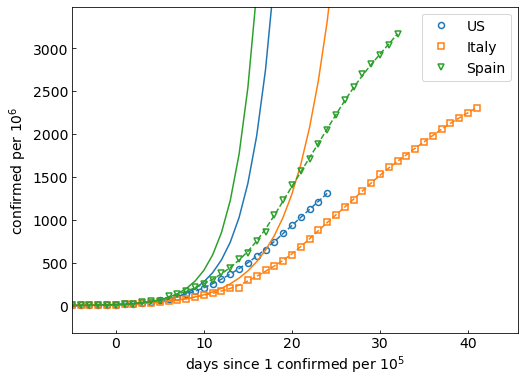

In [42]:
# confirmed per capita
N+=1; figure(N, figsize=figsize)
clf()
for i in range(nctry):
    ctryd = corona[countries[i]]
    days = ctryd["days"]
    plot(days, ctryd["cnf_pc"], sbl[i]+clr[i], mfc='none', mew=1.5, label=ctryd["name"])
    plot(days, ctryd["cnf_expfit"], '-'+clr[i], lw=1.5)
    plot(days, ctryd["cnf_pc_h"], '--'+clr[i])
scaled_max = max([corona[country]['cnf_pc'].max() for country in countries])
axis(xmin=-5, ymin=0-scaled_max*0.1, ymax=scaled_max*1.1)
xlabel('days since %i confirmed per $10^%i$' % (clinv_dig, clinv_exp))
#xlabel('days since %i deaths per $10^%i$' % (clinv_dig, clinv_exp))
#ylabel("confirmed per %1.0e" % mult)
ylabel("confirmed per $10^%i$" % np.log10(mult))
legend(loc='best')
if savefigs:
    savefig("confirmed_scaled.pdf", bbox_inches="tight")
    savefig("confirmed_scaled.png", bbox_inches="tight")

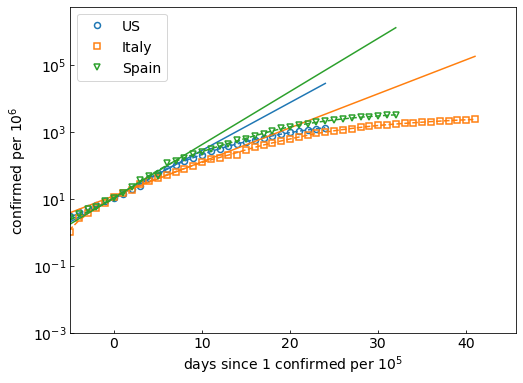

In [43]:
# log confirmed per capita
N+=1; figure(N, figsize=figsize)
clf()
for i in range(nctry):
    ctryd = corona[countries[i]]
    semilogy(ctryd["days"], ctryd["cnf_pc"], sbl[i]+clr[i], mfc='none', mew=1.5,
             label=ctryd["name"])
    semilogy(ctryd["days"], ctryd["cnf_expfit"], '-'+clr[i], lw=1.5)
    semilogy(ctryd["days"], ctryd["cnf_pc_h"], '--'+clr[i])
axis(xmin=-5, ymin=1e-3)
xlabel('days since %i confirmed per $10^%i$' % (clinv_dig, clinv_exp))
#xlabel('days since %i deaths per $10^%i$' % (clinv_dig, clinv_exp))
#ylabel("confirmed per %1.0e" % mult)
ylabel("confirmed per $10^%i$" % np.log10(mult))
legend(loc='best')

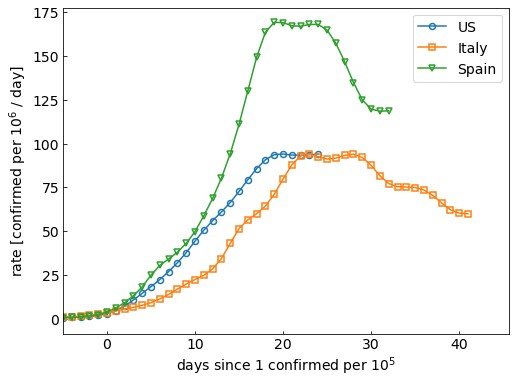

In [44]:
# rate confirmed per capita
N+=1; figure(N, figsize=figsize)
clf()
for i in range(nctry):
    ctryd = corona[countries[i]]
    plot(ctryd["days"], ctryd["cnf_rate"], "-"+sbl[i]+clr[i], mfc='none', mew=1.5,
         label=ctryd["name"])
axis(xmin = -5)
xlabel('days since %i confirmed per $10^%i$' % (clinv_dig, clinv_exp))
#xlabel('days since %i deaths per $10^%i$' % (clinv_dig, clinv_exp))
ylabel("rate [confirmed per $10^%i$ / day]" % np.log10(mult))
legend(loc="best")
if savefigs:
    savefig("confirmed_rate.png", bbox_inches="tight")

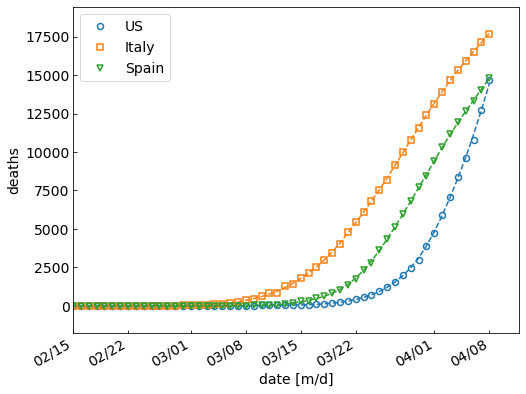

In [45]:
# total deaths, not scaled
N+=1; figure(N, figsize=figsize)
#figure(1, figsize=(4,3))
clf()
for i in range(nctry):
    ctryd = corona[countries[i]]
    population = ctryd['population']
    plot(dates, ctryd['dth'], sbl[i]+clr[i], mfc='none', mew=1.5, label=ctryd["name"])
    plot(dates, ctryd['dth_pc_h']*population/mult, '--'+clr[i])
ax = gca()
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%m/%d"))
setp(ax.get_xticklabels(), rotation=30, ha="right")
dth_max = max([corona[country]['dth'].max() for country in countries])
axis(xmin = datetime(year=2020, month=2, day = 15), ymin=0-dth_max*0.1, ymax = dth_max*1.1)
xlabel("date [m/d]")
ylabel("deaths")
legend(loc='best')
if savefigs:
    savefig("temp.pdf", bbox_inches="tight")

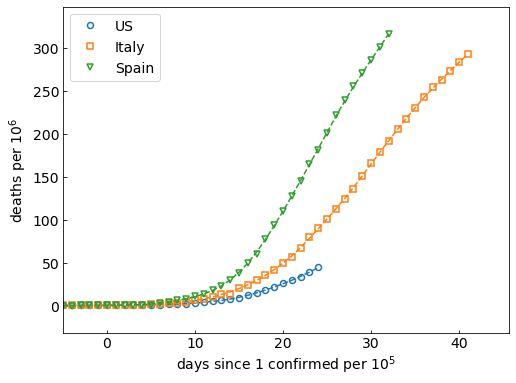

In [46]:
# deaths per capita
N+=1; figure(N, figsize=figsize)
clf()
for i in range(nctry):
    ctryd = corona[countries[i]]
    days = ctryd["days"]
    plot(days, ctryd["dth_pc"], sbl[i]+clr[i], mfc='none', mew=1.5, label=ctryd["name"])
    plot(days, ctryd["dth_pc_h"], '--'+clr[i])
scaled_max = max([corona[country]['dth_pc'].max() for country in countries])
axis(xmin=-5, ymin=0-scaled_max*0.1, ymax=scaled_max*1.1)
xlabel('days since %i confirmed per $10^%i$' % (clinv_dig, clinv_exp))
#xlabel('days since %i deaths per $10^%i$' % (clinv_dig, clinv_exp))
#ylabel("confirmed per %1.0e" % mult)
ylabel("deaths per $10^%i$" % np.log10(mult))
legend(loc='best')
if savefigs:
    savefig("temp.pdf", bbox_inches="tight")

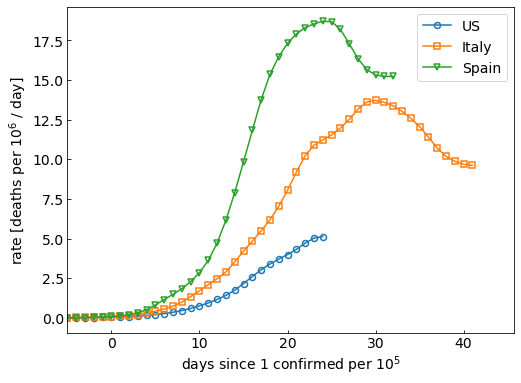

In [47]:
# rate deaths per capita
N+=1; figure(N, figsize=figsize)
clf()
for i in range(nctry):
    ctryd = corona[countries[i]]
    plot(ctryd["days"], ctryd["dth_rate"], "-"+sbl[i]+clr[i], mfc='none', mew=1.5,
         label=ctryd["name"])
axis(xmin = -5)
xlabel('days since %i confirmed per $10^%i$' % (clinv_dig, clinv_exp))
#xlabel('days since %i deaths per $10^%i$' % (clinv_dig, clinv_exp))
ylabel("rate [deaths per $10^%i$ / day]" % np.log10(mult))
legend(loc="best")
if savefigs:
    savefig("temp.png", bbox_inches="tight")

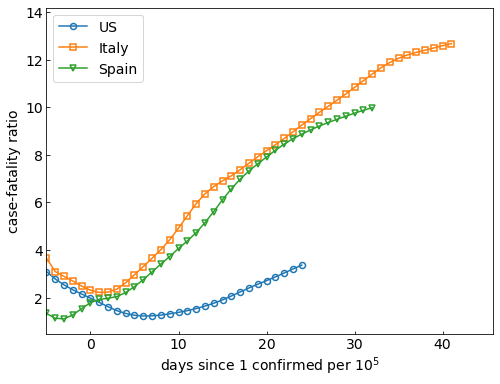

In [48]:
# case fatality ratio
N+=1; figure(N, figsize=figsize)
clf()
for i in range(nctry):
    ctryd = corona[countries[i]]
    plot(ctryd["days"], ctryd["dth_pc_h"]/ctryd["cnf_pc_h"]*100, "-"+sbl[i]+clr[i], mfc='none',
         mew=1.5, label=ctryd["name"])
axis(xmin = -5)
xlabel('days since %i confirmed per $10^%i$' % (clinv_dig, clinv_exp))
#xlabel('days since %i deaths per $10^%i$' % (clinv_dig, clinv_exp))
ylabel("case-fatality ratio")
legend(loc="best")
if savefigs:
    savefig("temp.png", bbox_inches="tight")

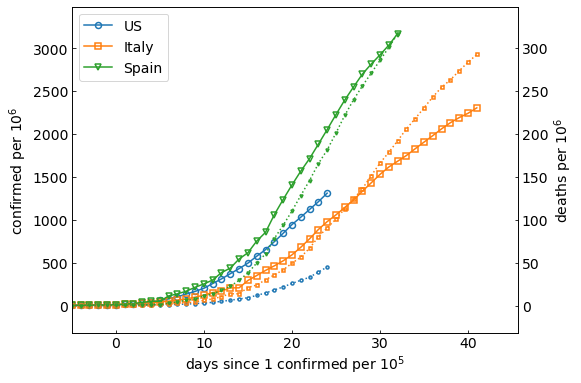

In [49]:
# confirmed per-capita cases and deaths on one graph
N+=1; figure(N, figsize=figsize)
clf()
ax1 = subplot(111)
ax2 = ax1.twinx()
for i in range(nctry):
    ctryd = corona[countries[i]]
    days = ctryd["days"]
    ax1.plot(days, ctryd["cnf_pc"], "-"+sbl[i]+clr[i], mfc='none', mew=1.5,
             label=ctryd["name"])
    ax2.plot(days, ctryd["dth_pc"], ":"+sbl[i]+clr[i], mfc='none', mew=1.5, ms=3)
    #plot(days, ctryd["dth_pc_h"], '--'+clr[i])
cnf_max = max([corona[country]['cnf_pc'].max() for country in countries])
dth_max = max([corona[country]['dth_pc'].max() for country in countries])
ax1.axis(xmin=-5, ymin=0-cnf_max*0.1, ymax=cnf_max*1.1)
ax2.axis(xmin=-5, ymin=0-dth_max*0.1, ymax=dth_max*1.1)
ax1.set_xlabel('days since %i confirmed per $10^%i$' % (clinv_dig, clinv_exp))
#ax1.set_xlabel('days since %i deaths per $10^%i$' % (clinv_dig, clinv_exp))
ax1.set_ylabel("confirmed per $10^%i$" % np.log10(mult))
ax2.set_ylabel("deaths per $10^%i$" % np.log10(mult))
handles, labels = ax1.get_legend_handles_labels()
legend(handles, labels, loc='best')
if savefigs:
    savefig("temp.pdf", bbox_inches="tight")